In [6]:
import pickle
import time
import importlib
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image, display
import asyncio

# addition
import cv2
import math
import os, io
import kachaka_api
from PIL import Image as im

import kachaka_base as base
importlib.reload(base)

<module 'kachaka_base' from '/home/kachaka/class/MSEP_2023/kikai_keisei_tsubomoto/kachaka_base.py'>

In [7]:
def wait_finish_command(client):
    # コマンド送信を待つ
    time.sleep(0.2)
    # time.sleep(0.5)
    # コマンドが終了するまで待つ
    while client.is_command_running():
        time.sleep(0.01)

In [8]:
from kachaka_base import BoxColor, PushingBoxStatus
import os
import shutil

class RealKachaka(base.KachakaBase):
    def __init__(self):
        super().__init__()
        self.client = kachaka_api.KachakaApiClient()  # 同期ライブラリ
        # 諸々を初期化
        self.client.update_resolver()
        self.client.set_auto_homing_enabled(False)
        self.update_sensor_count = 0
        self.update_sensor_data()
        self.camera_count = 0
        
        self.camera_output_dir = "camera_data"
        # 出力ディレクトリが存在する場合、削除して再作成
        if os.path.exists(self.camera_output_dir):
            shutil.rmtree(self.camera_output_dir)
        os.makedirs(self.camera_output_dir)

    def move_to_pose(self, distination: base.Pose):
        """指定した姿勢まで移動する

        Args:
            distination (base.Pose): 目標姿勢
        """
        ratio = 1000
        self.client.move_to_pose(
            distination.x / ratio, distination.y / ratio, distination.theta
        )
        wait_finish_command(self.client)
        self.update_sensor_data()

    def update_sensor_data(self):
        """センサーデータを更新する"""
        self.client.set_manual_control_enabled(True)

        scan = self.client.get_ros_laser_scan()
        theta = np.linspace(scan.angle_min, scan.angle_max, len(scan.ranges))
        dist = np.array(scan.ranges)

        position = self.client.get_robot_pose()
        position = {"x": position.x, "y": position.y, "theta": position.theta}

        ratio = 1000
        self.pose = base.Pose(
            position["x"] * ratio, position["y"] * ratio, position["theta"]
        )
        self.lidar_data = base.LidarData(dist, theta, self.pose)

        # ファイルをバイナリモードで開く
        # オブジェクトをシリアライズしてファイルに書き込む
        with open(
            "sensor_log/theta{}.pkl".format(self.update_sensor_count), "wb"
        ) as file:
            pickle.dump(theta, file)
        with open(
            "sensor_log/dist{}.pkl".format(self.update_sensor_count), "wb"
        ) as file:
            pickle.dump(dist, file)
        with open(
            "sensor_log/position{}.pkl".format(self.update_sensor_count), "wb"
        ) as file:
            pickle.dump(position, file)

        self.update_sensor_count += 1

    def recognize_box_color(self) -> base.BoxColor:
        """箱の色を認識する

        Returns:
            base.BoxColor: 赤or青
        """
        # 画像データ入手
        image = self.client.get_front_camera_ros_compressed_image()
        pic = np.array(im.open(io.BytesIO(image.data)), dtype=np.uint8)
        
        self.display_and_save_camera_image(image)

        # 判別
        RedPixels = []
        BluePixels = []
        # 写真の縦方向の画素の赤と青のピクセル数を数えてその列の色を決める．
        PixelContinue = False
        for i in range(0, len(pic[0]), 5):  # 横方向に回す
            RedSum = 0
            BlueSum = 0
            for j in range(len(pic) // 3, len(pic), 5):  # 縦方向に回す
                r, g, b = pic[j][i]
                # 赤色の場合
                if b <= 20 and r >= 40:
                    RedSum += [1, 5][PixelContinue]  # 連続性についての重み
                    PixelContinue = True
                else:
                    PixelContinue = False
                # 青色の場合
                if r <= 20 and b >= 40:
                    BlueSum += [1, 5][PixelContinue]  # 連続性についての重み
                    PixelContinue = True
                else:
                    PixelContinue = False
            RedPixels.append(RedSum)
            BluePixels.append(BlueSum)
        RedPixels = [x for x in RedPixels if x >= 10]
        BluePixels = [x for x in BluePixels if x >= 10]
        RedPixels.append(0)
        BluePixels.append(0)
        return [base.BoxColor.RED, base.BoxColor.BLUE][sum(RedPixels) < sum(BluePixels)]

    def check_pushing_box_by_camera(self) -> PushingBoxStatus:
        # 画像データ入手
        DataImageOrigin = self.client.get_front_camera_ros_compressed_image()
        ArrayPixels = np.array(
            im.open(io.BytesIO(DataImageOrigin.data)), dtype=np.uint8
        )
        
        self.display_and_save_camera_image(DataImageOrigin)

        RedPixels = []
        BluePixels = []
        # 写真の最下部分の画素の赤と青のピクセル数を数えて写真のある縦列の色を決める．
        IsSameColorWithPreColor = False
        CONTINUOUS_COLOR_WEIGHT = 5
        for IndexfromLeft in range(0, len(ArrayPixels[0])):  # 横方向に回す
            RedSum = 0
            BlueSum = 0
            r, _, b = ArrayPixels[-1][IndexfromLeft]
            # 赤色の場合
            if b <= 20 and r >= 40:
                RedSum += [1, CONTINUOUS_COLOR_WEIGHT][
                    IsSameColorWithPreColor
                ]  # 連続性についての重み
                IsSameColorWithPreColor = True
            else:
                IsSameColorWithPreColor = False
            # 青色の場合
            if r <= 20 and b >= 40:
                BlueSum += [1, CONTINUOUS_COLOR_WEIGHT][
                    IsSameColorWithPreColor
                ]  # 連続性についての重み
                IsSameColorWithPreColor = True
            else:
                IsSameColorWithPreColor = False
            RedPixels.append(RedSum)
            BluePixels.append(BlueSum)
        RedPixels = [Pixel if Pixel >= 1 else 0 for Pixel in RedPixels]
        BluePixels = [Pixel if Pixel >= 1 else 0 for Pixel in BluePixels]
        if sum(RedPixels) < sum(BluePixels):
            HolizonalColors = BluePixels
        else:
            HolizonalColors = RedPixels

        # 右，真ん中，左の色について平均を取る
        IMAGE_SPLIT_NUM = 10
        COLOR_DIFFERENCE_CORRECTION = 1
        TARGET_RANGE_PERCENT = 30

        TARGET_RANGE = TARGET_RANGE_PERCENT // IMAGE_SPLIT_NUM
        WIDTH_DIVIDED = len(HolizonalColors) // IMAGE_SPLIT_NUM
        ColorsOfCompressedPicture = []
        for IndexfromLeft in range(IMAGE_SPLIT_NUM):
            ColorsOfCompressedPicture.append(
                sum(
                    HolizonalColors[
                        WIDTH_DIVIDED
                        * IndexfromLeft : WIDTH_DIVIDED
                        * (IndexfromLeft + 1)
                        - 1
                    ]
                )
            )
        AverageLeftSideColor = np.average(ColorsOfCompressedPicture[:TARGET_RANGE])
        AverageCenterColor = np.average(
            ColorsOfCompressedPicture[TARGET_RANGE:-TARGET_RANGE]
        )
        AverageRightSideColor = np.average(ColorsOfCompressedPicture[-TARGET_RANGE:])

        # 右，真ん中，左に箱が寄ってると判定
        BiasDirectionOfPushedBox = None

        # 判定条件未定
        if AverageRightSideColor > AverageLeftSideColor + AverageCenterColor:
            BiasDirectionOfPushedBox = PushingBoxStatus.DROPPED_RIGHT
        elif AverageLeftSideColor > AverageRightSideColor + AverageCenterColor:
            BiasDirectionOfPushedBox = PushingBoxStatus.DROPPED_LEFT
        else:
            BiasDirectionOfPushedBox = PushingBoxStatus.PUSHING

        return BiasDirectionOfPushedBox
    
    def display_and_save_camera_image(self, get_front_camera_ros_compressed_image_data):
        image = Image(data=get_front_camera_ros_compressed_image_data.data, format="jpeg")
        display(image)
        # pil_image = im.fromarray(np.array(image))
        pil_image = im.fromarray(np.array(im.open(io.BytesIO(get_front_camera_ros_compressed_image_data.data)), dtype=np.uint8))
                
        pil_image.save(f"{self.camera_output_dir}/{self.camera_count}.jpg")
        self.camera_count += 1
        
    
    def make_zip_package(self):
        # もし既にzipファイルが存在する場合は削除
        if os.path.exists("camera_output.zip"):
            os.remove("camera_output.zip")
            
        shutil.make_archive("camera_output", "zip", self.camera_output_dir)

In [9]:
class ChatLogger(base.ILogger):
    def __init__(self, kachaka_client):
        self.client = kachaka_client
        self.history: list[str] = []

    def log(self, message: str) -> None:
        print(message)
        self.client.speak(message)
        wait_finish_command(self.client)
        self.history.append(message)


    def show_history(self):
        for message in self.history:
            print(message)

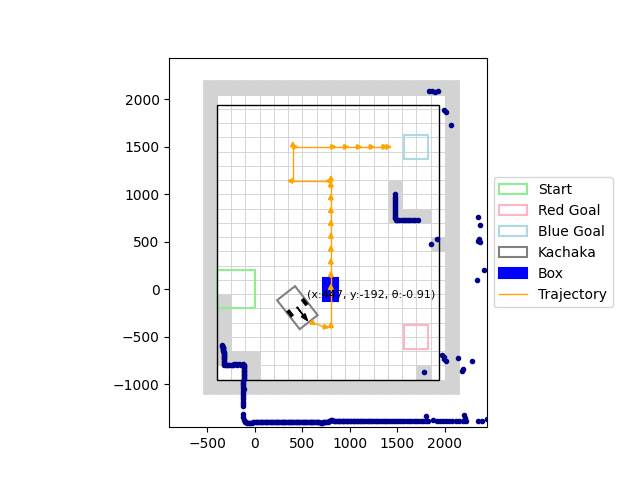

In [ ]:
# 初期化処理 ===============================================================
# 現実のカチャカ初期化---------------------
kachaka = RealKachaka()
logger = ChatLogger(kachaka.client)
logger.log("起動しました")

# 共通の初期化処理-------------------------
initial_box_pose = base.Pose(800, 0, 0)
red_box_goal = base.Pose(1700, -500, 0)
blue_box_goal = base.Pose(1700, 1500, 0)
box = base.Box(initial_box_pose)
map = base.GridMap(
    base.Size(2340, 2890),
    grid_size=base.Size(150, 150),
    origin_offset=base.Pose(400, 950, 0),
    start=base.Pose(-200, 0, 0),
    initial_box_pose=initial_box_pose,
    red_box_goal=red_box_goal,
    blue_box_goal=blue_box_goal,
)
trajectory_planner = base.StraightTrajectoryPlanner()
controller = base.Controller(kachaka, box, map, trajectory_planner, logger)

(x_lim, y_lim) = map.get_axes_lim()
margin = 500  # 表示マージン確保
x_lim = (x_lim[0] - margin, x_lim[1] + margin)
y_lim = (y_lim[0] - margin, y_lim[1] + margin)
plotter = base.Plotter(x_lim, y_lim)

# メインループ ===============================================================
while controller.are_all_tasks_done() == False:
    plotter.update(map, box, kachaka, controller.trajectory)
    controller.update()

# GIFアニメーション作成 ======================================================
plotter.close()
plotter.make_gif()
plotter.make_zip_package()

In [11]:
# スタート地点
kachaka.move_to_pose(base.Pose(100,0,0))

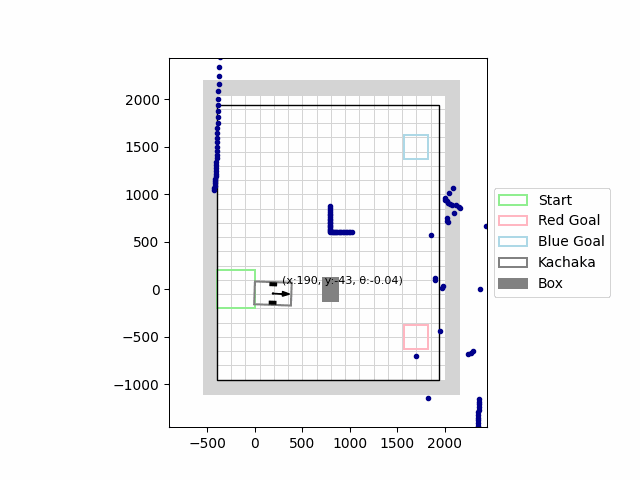

起動しました
センサ情報を更新します
箱の前まで移動します
箱の色を読みとります
   青の箱を検出しました
箱を運ぶ経路を生成します
経路を辿ります
タスクが完了しました


In [31]:
from IPython.display import Image, display

# 生成したGIFアニメーションを表示
display(Image(filename="plotter_output/animation.gif"))
# ログの履歴を表示
logger.show_history()